### Dataset source link
https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

### Problem Statement

Online platforms like Amazon receive millions of customer reviews every day. Manually analyzing this feedback is time-consuming and impractical.
The goal of this project is to automatically analyze customer reviews using Natural Language Processing and Machine Learning techniques to classify sentiment as positive, negative, or neutral, and extract actionable insights that can help businesses improve product quality and customer satisfaction.

In [1]:
import nltk
nltk.data.path.append(r"C:\Users\amenj\AppData\Roaming\nltk_data")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amenj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amenj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amenj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("Reviews.csv")

df = df[['Score', 'Summary', 'Text','Time']]
df.dropna(inplace=True)

print(df.shape)
print(df.head())
df.columns

(568427, 4)
   Score                Summary  \
0      5  Good Quality Dog Food   
1      1      Not as Advertised   
2      4  "Delight" says it all   
3      2         Cough Medicine   
4      5            Great taffy   

                                                Text        Time  
0  I have bought several of the Vitality canned d...  1303862400  
1  Product arrived labeled as Jumbo Salted Peanut...  1346976000  
2  This is a confection that has been around a fe...  1219017600  
3  If you are looking for the secret ingredient i...  1307923200  
4  Great taffy at a great price.  There was a wid...  1350777600  


Index(['Score', 'Summary', 'Text', 'Time'], dtype='object')

In [4]:
df = df.sample(50000, random_state=42)
print("Dataset size after sampling:", df.shape)

Dataset size after sampling: (50000, 4)


In [5]:
#sentiment distribution 
sentiment_percent = df['Score'].value_counts(normalize=True) * 100
print(sentiment_percent)

Score
5    64.180
4    14.106
1     9.134
3     7.390
2     5.190
Name: proportion, dtype: float64


In [6]:
def get_sentiment(score):
    if score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df['Sentiment'] = df['Score'].apply(get_sentiment)
df['Sentiment'].value_counts()


Sentiment
Positive    39143
Negative     7162
Neutral      3695
Name: count, dtype: int64

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['CleanReview'] = (df['Summary'] + " " + df['Text']).apply(clean_text)

df[['Text', 'CleanReview']].head()

,Text,CleanReview
41434,These are actually very tasty. Pure potatoes ...,like actually tasty pure potato great texture ...
209481,I realize that taste is a matter of personal p...,good subjectively star realize taste matter pe...
247306,This is one of my Favorite cup of soup choices...,lipton cup soup spring vegetable oz one favori...
80089,If you like the classic taste of a good margar...,suited purpose quite goal like classic taste g...
218580,I was willing to give this a chance even after...,taste artificial willing give chance even read...


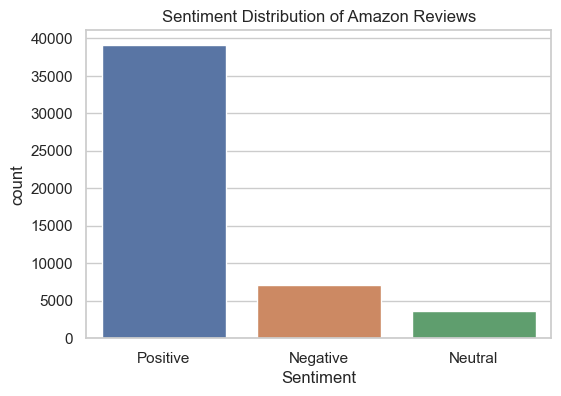

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment',palette='deep',hue='Sentiment',legend=False)
plt.title("Sentiment Distribution of Amazon Reviews")
plt.show()

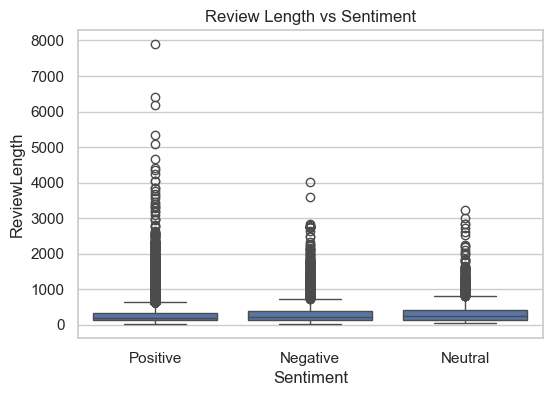

In [23]:
df['ReviewLength'] = df['CleanReview'].str.len()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Sentiment', y='ReviewLength')
plt.title("Review Length vs Sentiment")
plt.show()

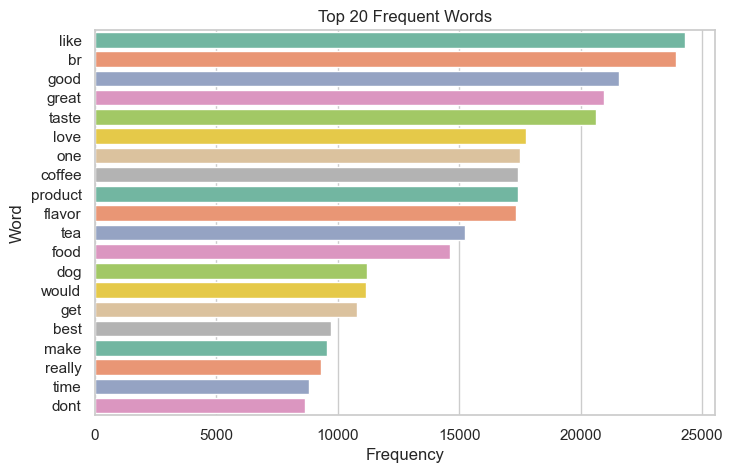

In [13]:
all_words = " ".join(df['CleanReview']).split()
common_words = Counter(all_words).most_common(20)

freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(8,5))
sns.barplot(data=freq_df, x='Frequency', y='Word', palette='Set2',hue='Word',legend=False)
plt.title("Top 20 Frequent Words")
plt.show()

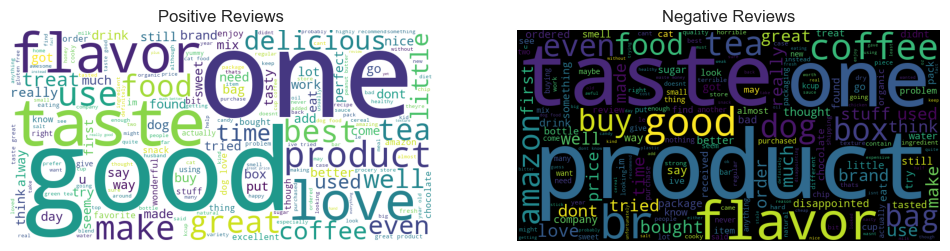

In [14]:
positive_text = " ".join(df[df['Sentiment']=="Positive"]['CleanReview'])
negative_text = " ".join(df[df['Sentiment']=="Negative"]['CleanReview'])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Negative Reviews")

plt.show()

In [15]:
vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9
)

X = vectorizer.fit_transform(df['CleanReview'])
y = df['Sentiment']

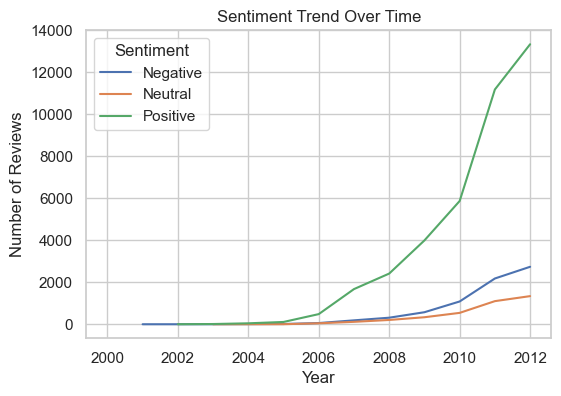

In [22]:
# Sentiment Trend Over Time
df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

year_sentiment = df.groupby(['Year', 'Sentiment']).size().unstack()

year_sentiment.plot(figsize=(6,4))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    
    print("\n", name)
    print("Accuracy:", acc)
    print(classification_report(y_test, preds))


 Logistic Regression
Accuracy: 0.8731
              precision    recall  f1-score   support

    Negative       0.79      0.66      0.72      1432
     Neutral       0.55      0.14      0.22       739
    Positive       0.89      0.98      0.93      7829

    accuracy                           0.87     10000
   macro avg       0.75      0.59      0.62     10000
weighted avg       0.85      0.87      0.85     10000


 Naive Bayes
Accuracy: 0.8285


C:\Users\amenj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amenj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amenj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amenj\anaconda3\Lib\site-packag

              precision    recall  f1-score   support

    Negative       0.86      0.34      0.49      1432
     Neutral       0.00      0.00      0.00       739
    Positive       0.83      1.00      0.90      7829

    accuracy                           0.83     10000
   macro avg       0.56      0.45      0.46     10000
weighted avg       0.77      0.83      0.78     10000


 Linear SVM
Accuracy: 0.8806
              precision    recall  f1-score   support

    Negative       0.77      0.72      0.75      1432
     Neutral       0.52      0.26      0.34       739
    Positive       0.91      0.97      0.94      7829

    accuracy                           0.88     10000
   macro avg       0.74      0.65      0.68     10000
weighted avg       0.86      0.88      0.87     10000



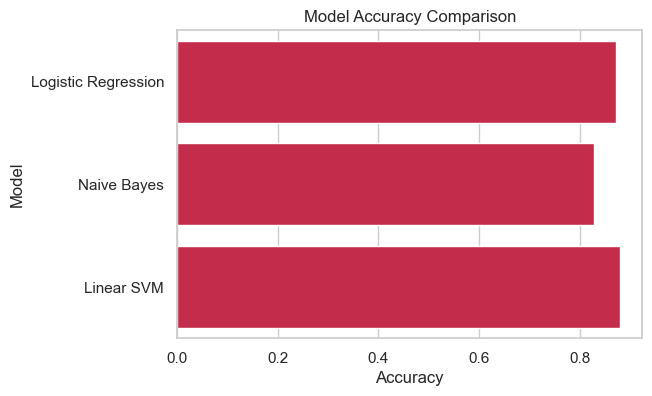

In [19]:
result_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy'])

plt.figure(figsize=(6,4))
sns.barplot(data=result_df, x='Accuracy', y='Model',color='crimson')
plt.title("Model Accuracy Comparison")
plt.show()

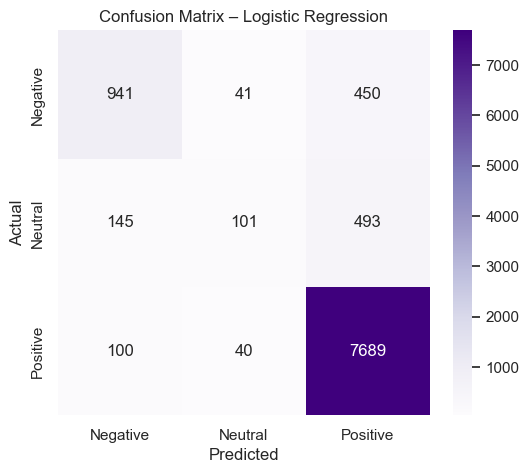

In [20]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

In [21]:
sample_review = ["The product quality is horrible and not worth the money"]
sample_vec = vectorizer.transform(sample_review)

print("Review:", sample_review[0])
print("Predicted Sentiment:", best_model.predict(sample_vec)[0])

Review: The product quality is horrible and not worth the money
Predicted Sentiment: Negative
